In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
import mysql.connector
import pickle

%matplotlib inline

In [2]:
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [3]:
# Connect to MySQL database
conn = mysql.connector.connect(host='127.0.0.1', user='root', passwd=password)
cursor = conn.cursor()

#Select the database
cursor.execute("USE vanguard")

In [4]:
cursor.execute("""
                    SELECT clients.client_id,
                        clients.clnt_age, 
                        clients.gendr, 
                        COUNT(distinct(interactions.process_step)) AS count_of_steps,
                        group_id.variation
                    FROM clients
                    JOIN interactions
                    ON clients.client_id = interactions.client_id
                    INNER JOIN group_id
                    ON group_id.client_id = clients.client_id
                    GROUP BY clients.client_id, clients.clnt_age, clients.gendr,group_id.variation;

                    """)
results = cursor.fetchall()

how_far = pd.DataFrame(results)

In [5]:
#rename columns to be descriptive

how_far.rename(columns = {0:'client_id',1:'age',2:'gender',3:'steps_reached',4:'group_status'},inplace=True)
how_far

# Frequency table 
frequency_table = how_far['steps_reached'].value_counts()

# Calculating the proportion of people that reached and stopped at each step
proportion_table = how_far['steps_reached'].value_counts(normalize=True)

proportion_table, frequency_table


(steps_reached
 5    0.664238
 1    0.118436
 4    0.093129
 2    0.069347
 3    0.054851
 Name: proportion, dtype: float64,
 steps_reached
 5    33544
 1     5981
 4     4703
 2     3502
 3     2770
 Name: count, dtype: int64)

In [6]:
how_far

,client_id,age,gender,steps_reached,group_status
0,1000062,52.5,F,5,Control
1,1000353,59.0,U,5,Control
2,1000536,27.0,U,5,Control
3,1000672,65.5,F,5,Control
4,1001101,61.5,M,5,Test
...,...,...,...,...,...
50495,9999150,30.0,U,2,Test
50496,9999400,28.5,U,5,Test
50497,9999626,35.0,M,2,Test
50498,9999729,31.0,F,5,Test


<Axes: xlabel='steps_reached,group_status'>

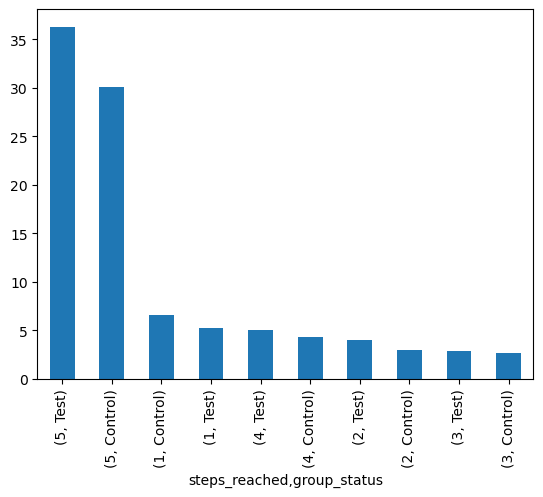

In [7]:
proportion_status = how_far[['steps_reached','group_status']].value_counts(normalize=True)
proportion_percent = proportion_status * 100 
proportion_percent

#bar with test groups proportions
proportion_percent.plot(kind="bar")

How to calculate abandonment rate Abandonment rate = (Number of intended tasks completed) / (Number of intended tasks initiated) x 100

How to calculate cart abandonment rate for ecommerce stores

Cart abandonment rate = (Number of carts abandoned / Number of orders initiated) x 100

In [8]:
proportion_status

how_far['steps_reached'].value_counts()

steps_reached
5    33544
1     5981
4     4703
2     3502
3     2770
Name: count, dtype: int64

In [9]:
#assuming everyone who completed went through all 5 steps
completed =  33544
dnf = 16956
initiated = 50500

# Calculate abandonment rate
abandonment_rate = (dnf / initiated) * 100
completion_rate = (completed / initiated) * 100

# Print abandonment rate
print("Abandonment rate of full group: {:.2f}%".format(abandonment_rate))
print("Completion rate of full group: {:.2f}%".format(completion_rate))



Abandonment rate of full group: 33.58%
Completion rate of full group: 66.42%


In [10]:
#let's look at the control group
with open('control_dnf.pkl', 'rb') as f:
    control_dnf = pickle.load(f)

control_dnf

with open('control_confirmed.pkl', 'rb') as f:
    control_confirmed = pickle.load(f)

control_confirmed

#8098 people from the control group abandoned the process
#15434 people from the control group completed the process
#the control group in total is 23532


#assuming everyone who completed went through all 5 steps
complete_control = 15434
dnf_control = 8098
initiated = 23532

# Calculate abandonment rate
abandonment_rate_control = (dnf_control / initiated) * 100
completion_rate_control = (complete_control / initiated) * 100

# Print abandonment rate
print("Abandonment rate of control group: {:.2f}%".format(abandonment_rate))
print("Completion rate of control group: {:.2f}%".format(completion_rate))


Abandonment rate of control group: 33.58%
Completion rate of control group: 66.42%


In [17]:
#let's look at the test group
with open('test_dnf.pkl', 'rb') as f:
    test_dnf = pickle.load(f)


with open('test_confirmed.pkl', 'rb') as f:
    test_confirmed = pickle.load(f)

# 8281 people from the test group abandoned the process
# 18687 people from the test group completed the process
# the test group in total is 26968


#assuming everyone who completed went through all 5 steps
complete_test = 18687
dnf_test = 8281
initiated = 26968

# Calculate abandonment rate
abandonment_rate_control = (dnf_test / initiated) * 100
completion_rate_control = (complete_test / initiated) * 100

# Print abandonment rate
print("Abandonment rate of test group: {:.2f}%".format(abandonment_rate))
print("Completion rate of test group: {:.2f}%".format(completion_rate))

Abandonment rate of control group: 33.58%
Completion rate of control group: 66.42%


In [20]:
#Completion rates
# Control group data
complete_control = 15434
dnf_control = 8098
initiated_control = 23532

# Test group data
complete_test = 18687
dnf_test = 8281
initiated_test = 26968

# Calculate completion rates
completion_rate_control = complete_control / initiated_control
completion_rate_test = complete_test / initiated_test

# Calculate the standard error
p1 = completion_rate_control
p2 = completion_rate_test
n1 = initiated_control
n2 = initiated_test
se = np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)

# Calculate the z-score
z = (p2 - p1) / se

# Calculate the p-value from the z-score
p_value = 2 * (1 - st.norm.cdf(abs(z)))

print("Completion rate (control):", p1 * 100)
print("Completion rate (test):", p2 * 100)
print("The difference between control and test:",(p2 * 100-p1 * 100))
print("Standard Error (SE):", se)
print("z-score:", z)
print("p-value:", "{:.20f}".format(p_value))

Completion rate (control): 65.58728539860616
Completion rate (test): 69.29323642835953
The difference between control and test: 3.705951029753379
Standard Error (SE): 0.004181068613502637
z-score: 8.863645570859866
p-value: 0.00000000000000000000


In [21]:
# Completion rates
# Control group data
complete_control = 15434
dnf_control = 8098
initiated_control = 23532

# Test group data
complete_test = 18687
dnf_test = 8281
initiated_test = 26968

# Calculate completion rates
completion_rate_control = complete_control / initiated_control
completion_rate_test = complete_test / initiated_test

# Calculate the z-score
# Here, we remove the standard error calculation
p1 = completion_rate_control
p2 = completion_rate_test
z = (p2 - p1)

# Calculate the p-value from the z-score
p_value = 2 * (1 - st.norm.cdf(abs(z)))

print("Completion rate (control):", p1 * 100)
print("Completion rate (test):", p2 * 100)
print("The difference between control and test:", (p2 * 100 - p1 * 100))
print("z-score:", z)
print("p-value:", "{:.20f}".format(p_value))

Completion rate (control): 65.58728539860616
Completion rate (test): 69.29323642835953
The difference between control and test: 3.705951029753379
z-score: 0.03705951029753385
p-value: 0.97043755593695291140


In [24]:
# Abandonment rates
# Control group data
complete_control = 15434
dnf_control = 8098
initiated_control = 23532

# Test group data
complete_test = 18687
dnf_test = 8281
initiated_test = 26968

# Calculate abandonment rates
abandonment_rate_control = dnf_control / initiated_control
abandonment_rate_test = dnf_test / initiated_test

# Calculate the z-score directly from the abandonment rates
p1 = abandonment_rate_control
p2 = abandonment_rate_test
z = (p2 - p1)

# Calculate the p-value from the z-score
p_value = 2 * (1 - st.norm.cdf(abs(z)))

print("Abandonment rate (control):", p1 * 100)
print("Abandonment rate (test):", p2 * 100)
print("The difference between control and test:", (p2 * 100 - p1 * 100))
print("z-score:", z)
print("p-value:", "{:.20f}".format(p_value))


Abandonment rate (control): 34.412714601393844
Abandonment rate (test): 30.70676357164046
The difference between control and test: -3.7059510297533826
z-score: -0.03705951029753385
p-value: 0.97043755593695291140


## Conclusions

The completion rates for the test group were better than the control group by about 3.70%.
The abandonment rates for the test group were better than the control group with a decrease of about-3.70%

That said, the observed increase in completion rate does not meet the company's threshold of 5%, meaning the time, energy and resources needed to update the site would not be worth it. 

In the context of our hypotheses:

The null hypothesis (H0) states that there is no difference in completion rates between the old and new website designs.
The alternative hypothesis (HA) suggests that the new website design improves completion rates.
Since the p-value is high (greater than the conventional significance level of 0.05), we fail to reject the null hypothesis. Therefore, based on this analysis, there is insufficient evidence to conclude that the new website design improves completion rates compared to the old design.